In [1]:
#Test fit slit profiles for determining the 1 sigma width of the PSF for possibly using standard stars for absolute flux calibration

In [2]:
#Import libraries
import json
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting

In [3]:
#Modify these
path_to_IGRINS_PLP = 'Volumes/IGRINS_Data_Backup/plp'
date = '20151206'
frameno = '0075'
band = 'K'
slit_length = 14.8 #arcsec, McDonald

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0003337234677701136
            Iterations: 28
            Function evaluations: 255
            Gradient evaluations: 28
FWHM A beam: 1.2528287525779984
FWHM B beam: 1.14430555596597


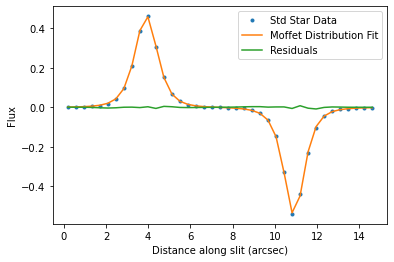

In [12]:
#Read in slit profile file outputted by IGRINS PLP
json_file = open(path_to_IGRINS_PLP+'/outdata/'+date+'/SDC'+band+'_'+date+'_'+frameno+'.slit_profile.json')
json_obj = json.load(json_file)
x = np.array(json_obj['profile_x']) * slit_length
y = np.array(json_obj['profile_y'])

#Fit 2 Moffet distributions to the psfs from A and B positions (see https://docs.astropy.org/en/stable/modeling/compound-models.html)
g1 = models.Moffat1D(amplitude=0.5, x_0=4.0, alpha=1.0, gamma=1.0)
g2 = models.Moffat1D(amplitude=-0.5, x_0=11.0, alpha=1.0, gamma=1.0)
gg_init = g1 + g2
fitter = fitting.SLSQPLSQFitter()
gg_fit = fitter(gg_init, x, y)

#Print FWHM
print('FWHM A beam:', gg_fit[0].fwhm)
print('FWHM B beam:', gg_fit[1].fwhm)

#Plot results
plt.plot(x, y, '.', label='Std Star Data')
plt.plot(x, gg_fit(x), label='Moffet Distribution Fit')
plt.plot(x, y-gg_fit(x), label='Residuals')
plt.xlabel('Distance along slit (arcsec)')
plt.ylabel('Flux')
plt.legend()

Fraction of light through slit:  0.48448870670110467


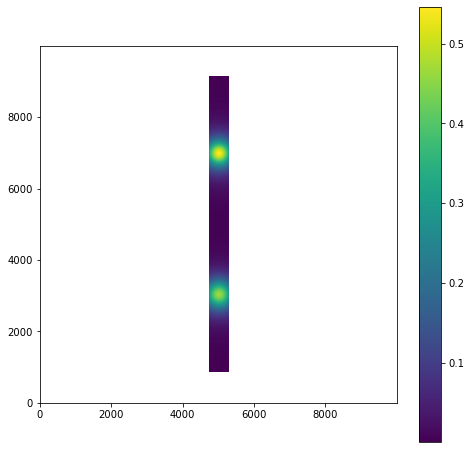

In [11]:
#Numerically estimate light through slit

#Create 2D Moffat distribution models from the 1D slit profile fits
g1_fit = models.Moffat2D(amplitude=np.abs(gg_fit[0].amplitude) , x_0=gg_fit[0].x_0 - 0.5*slit_length, alpha=gg_fit[0].alpha, gamma=gg_fit[0].gamma)
g2_fit = models.Moffat2D(amplitude=np.abs(gg_fit[1].amplitude), x_0=gg_fit[1].x_0 - 0.5*slit_length, alpha=gg_fit[1].alpha, gamma=gg_fit[1].gamma)

#Generate a 2D grid in x and y for numerically calculating slit loss
n_axis = 10000
half_n_axis = n_axis / 2
dx = 1.2 * (slit_length / n_axis)
dy = 1.2 * (slit_length / n_axis)
y2d, x2d = np.meshgrid(np.arange(n_axis), np.arange(n_axis))
x2d = (x2d - half_n_axis) * dx
y2d = (y2d - half_n_axis) * dy

#Perform numerical integration for total flux ignoring slit losses
profiles_2d = g1_fit(x2d, y2d) + g2_fit(x2d, y2d)
f_total = np.nansum(profiles_2d) * dx * dy

#Perform numerical integration for flux through slit by masking out pixels outside of the slit
slit_width_to_length_ratio = 1.0/14.8
slit_width = slit_length * slit_width_to_length_ratio
outside_slit = (y2d <= -0.5*slit_width) | (y2d >= 0.5*slit_width) | (x2d <= -0.5*slit_length) | (x2d >= 0.5*slit_length)
profiles_2d[outside_slit] = np.nan
f_inside = np.nansum(profiles_2d) * dx * dy

#Plot and print results
print('Estimated fraction of light through slit: ', f_inside/f_total)
plt.figure(figsize=[8,8])
plt.imshow(profiles_2d, origin='lower')
plt.colorbar()